# Pré traitement des données

## I. Conversion C3D en JSON rééchantilloné à 50 Hz

In [1]:
import numpy as np
import ezc3d
import json
from scipy.signal import resample,butter, lfilter, freqz
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#c3d = ezc3d.c3d(file_path)
#events = c3d['parameters']['EVENT']['LABELS']['value'] # Récupérer les événements
#temps_events = c3d['parameters']['EVENT']['TIMES']['value'] # Récupérer les temps correspondant aux événements

In [3]:
# fichier_brut_6 = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATA_FOG/MORETTY_Daniel_1963-06-23_MODA1963/2023-07-07/2023-07-07_overlay_unspecified/Video overlay 3.c3d"
# c3d = ezc3d.c3d(fichier_brut_6)
# events = c3d['parameters']['EVENT']['LABELS']['value'] # Récupérer les événements
# temps_events = c3d['parameters']['EVENT']['TIMES']['value'] # Récupérer les temps correspondant aux événements

# dict_events = {}

# df = pd.DataFrame({'events': events, 'frames': temps_events[0]})
# print(df)

In [4]:
def recuperer_evenements(file_path):
    """
    Cette fonction extrait les événements du fichier C3D.

    Args:
        file_path (str): Le chemin du fichier C3D.

    Returns:
        dict: Un dictionnaire contenant les événements et leur temps correspondant.
    """
    c3d = ezc3d.c3d(file_path)
    events = c3d['parameters']['EVENT']['LABELS']['value'] # Récupérer les événements
    temps_events = c3d['parameters']['EVENT']['TIMES']['value'] # Récupérer les temps correspondant aux événements
    # Créer un DataFrame
    df = pd.DataFrame({'events': events, 'frames': temps_events[1]})
    # Supprimer l'index
    df.reset_index(drop=True, inplace=True)
    events_dict = df.groupby('events')['frames'].apply(list).to_dict() #self.events final
    return events_dict

def butter_lowpass(cutoff, fs, order=2):
    """
    Crée les coefficients d'un filtre Butterworth passe-bas.

    Args:
        cutoff (float): Fréquence de coupure du filtre.
        fs (float): Fréquence d'échantillonnage du signal.
        order (int): Ordre du filtre.

    Returns:
        tuple: Coefficients du filtre (b, a).
    """
    nyq = 0.5 * fs # Fréquence de Nyquist
    normal_cutoff = cutoff / nyq # Fréquence de coupure normalisée
    b, a = butter(order, normal_cutoff, btype='low', analog=False) # Création des coefficients du filtre
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    """
    Applique un filtre Butterworth passe-bas à un signal.

    Args:
        data (array_like): Signal à filtrer.
        cutoff (float): Fréquence de coupure du filtre.
        fs (float): Fréquence d'échantillonnage du signal.
        order (int): Ordre du filtre.

    Returns:
        array_like: Signal filtré.
    """
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def reechantillonnage_fc_coupure_et_association_labels_et_data(file_path, cutoff_freq=20, target_freq=50):
    """
    Cette fonction transforme les données échantillonnées à 2100 Hz en données échantillonnées à 50 Hz,
    puis applique un filtre Butterworth passe-bas avec une fréquence de coupure de 20 Hz, et enfin associe les étiquettes des données aux données rééchantillonnées et filtrées.

    Args:
        file_path (str): Le chemin du fichier C3D.
        cutoff_freq (float): Fréquence de coupure du filtre Butterworth (20 Hz).
        target_freq (float): Fréquence cible après rééchantillonnage (50 Hz).

    Returns:
        tuple: Un tuple contenant un dictionnaire fusionnant les étiquettes et les données rééchantillonnées et filtrées, et les temps rééchantillonnés.
    """
    c3d = ezc3d.c3d(file_path)
    labels = c3d['parameters']['ANALOG']['LABELS']['value'] # Récupérer les étiquettes des données
    original_freq = c3d['parameters']['ANALOG']['RATE']['value'][0] # Récupérer la fréquence d'échantillonnage
    data = c3d['data']['analogs'] # Récupérer les données
    nb_frame = len(data[0][0]) # Récupérer le nombre de frames
    target_freq = 50  # fréquence de rééchantillonnage
    
    # Rééchantillonnage des données
    nb_samples_target = int(nb_frame * (target_freq / original_freq)) # Calcul du nombre d'échantillons cible
    resampled_times = np.linspace(0., (nb_frame / original_freq), num=nb_samples_target) # Création d'un tableau de temps rééchantillonné
    resampled_data = np.zeros((len(labels), nb_samples_target)) # Création d'un tableau de zéros de la taille des données rééchantillonnées
    for i in range(len(labels)): # Pour chaque étiquette
        resampled_data[i, :] = resample(data[0][i, :], nb_samples_target) # Rééchantillonnage des données

    fusion_label_data = {}
    for i, label in enumerate(labels): # Pour chaque étiquette
        fusion_label_data[label] = resampled_data[i, :] # Associer les étiquettes aux données rééchantillonnées
        
    filtered_fusion_label_data = {}  # Initialiser un dictionnaire pour stocker les données filtrées

    for label, data in fusion_label_data.items():  # Itérer sur chaque étiquette et signal
        filtered_signal = butter_lowpass_filter(data, cutoff_freq, target_freq)  # Appliquer le filtre Butterworth
        filtered_fusion_label_data[label] = filtered_signal  # Stocker le signal filtré dans le dictionnaire de données filtrées
    
    return filtered_fusion_label_data, resampled_times
    

def filtrer_labels(filtered_fusion_label_data):
    """
    Cette fonction filtre les étiquettes des données pour ne garder que celles liées à l'accéléromètre et au gyroscope.

    Args:
        fusion_label_data (dict): Dictionnaire contenant les étiquettes et les données associées.

    Returns:
        tuple: Un tuple contenant une liste des étiquettes filtrées et un dictionnaire des données associées aux étiquettes filtrées.
    """
    labels_filtre = []
    labels_data_filtre = {}
    for label, valeurs in filtered_fusion_label_data.items(): # Pour chaque étiquette et ses valeurs
        if 'ACC' in label or 'GYRO' in label: # Si l'étiquette contient 'ACC' ou 'GYRO'
            labels_filtre.append(label) # Ajouter l'étiquette à la liste des étiquettes filtrées
            labels_data_filtre[label] = valeurs # Ajouter les valeurs associées à l'étiquette dans le dictionnaire des données filtrées
    return labels_filtre, labels_data_filtre

def calcul_norme(labels_data_filtre):
    """
    Cette fonction calcule les normes des données filtrées.

    Args:
        labels_data_filtre (dict): Dictionnaire contenant les étiquettes et les données associées, filtrées.

    Returns:
        dict: Un dictionnaire contenant les normes calculées.
    """
    normes = {}
    traite = set() # Créer un ensemble vide pour stocker les capteurs, les côtés et les mesures déjà traités
    for key, value in labels_data_filtre.items():
        parts = key.split('_') # Séparer l'étiquette en parties
        sensor = parts[0] # Récupérer le capteur
        side = parts[1] # Récupérer le côté
        measure = parts[2] # Récupérer la mesure (GYRO ou ACC)
        
        if (sensor, side, measure) not in traite: # Si le capteur, le côté et la mesure n'ont pas déjà été traités
            traite.add((sensor, side, measure)) # Ajouter le capteur, le côté et la mesure à l'ensemble des éléments traités
            
            if "ACC" in measure:
                # Obtention des axes X, Y et Z
                axe_X = (labels_data_filtre[f'{sensor}_{side}_{measure}_X'])
                axe_Y = (labels_data_filtre[f'{sensor}_{side}_{measure}_Y'])
                axe_Z = (labels_data_filtre[f'{sensor}_{side}_{measure}_Z'])
            
                norme = np.sqrt(axe_X**2 + axe_Y**2 + axe_Z**2) - 1 # Calcul de la norme auquelle on soustrait 1 pour enlever la gravité
                nom_cle = f'{sensor}_{side}_{measure}_norme'
                normes[nom_cle] = norme
                
            else:
                axe_X = labels_data_filtre[f'{sensor}_{side}_{measure}_X']
                axe_Y = labels_data_filtre[f'{sensor}_{side}_{measure}_Y']
                axe_Z = labels_data_filtre[f'{sensor}_{side}_{measure}_Z']
        
                norme = np.sqrt(axe_X**2 + axe_Y**2 + axe_Z**2) 
                nom_cle = f'{sensor}_{side}_{measure}_norme'
                normes[nom_cle] = norme

    return normes

def creer_structure_json(labels_data_filtre, patient_id, date_de_naissance, medicaments, resampled_times, events_dict, normes):
    """
    Cette fonction crée une structure JSON à partir des données filtrées et d'autres informations.

    Args:
        labels_data_filtre (dict): Dictionnaire contenant les étiquettes et les données associées, filtrées.
        patient_id (int): Identifiant du patient.
        date_de_naissance (str): Date de naissance du patient.
        medicaments (str): Médicaments pris par le patient.
        resampled_times (ndarray): Temps rééchantillonné.
        events_dict (dict): Dictionnaire contenant les événements et leur temps correspondant.
        normes (dict): Dictionnaire contenant les normes calculées.

    Returns:
        dict: Structure JSON contenant les données et les métadonnées.
    """
    json_data = {
        "metadata": {
            "Details du patient": {
                "Identifiant": patient_id,
                "Date de naissance": date_de_naissance,
                "Medicaments": medicaments
            },
            "Temps": resampled_times.tolist()
        }
    }
    
    for key, value in labels_data_filtre.items():
        parts = key.split('_')
        sensor = parts[1]
        side = parts[0]
        measure = parts[2]
        axis = parts[3]
        
        if sensor not in json_data:
            json_data[sensor] = {}

        if side not in json_data[sensor]:
            json_data[sensor][side] = {}

        if measure not in json_data[sensor][side]:
            json_data[sensor][side][measure] = {}

        json_data[sensor][side][measure][axis] = value.tolist()
        
    for key in normes:
        parts = key.split('_')
        sensor = parts[1]
        side = parts[0]
        measure = parts[2]
        axis = parts[3]

        if sensor not in json_data:
            json_data[sensor] = {}

        if side not in json_data[sensor]:
            json_data[sensor][side] = {}

        if measure not in json_data[sensor][side]:
            json_data[sensor][side][measure] = {}

        # Insérer la norme au même niveau d'indentation que l'axe
        json_data[sensor][side][measure][axis] = value.tolist()
        json_data[sensor][side][measure]["norme"] = normes[key].tolist()
    
        # # Ajouter les événements FOG
        # json_data["FOG"] = {
        #     "Debut": events_dict["FOG_begin"],
        #     "Fin": events_dict["FOG_end"]
        # }
    
        # # Ajouter tous les évènements sauf FOG
        # del events_dict["FOG_begin"]
        # del events_dict["FOG_end"]
            
    if "FOG_begin" in events_dict and "FOG_end" in events_dict:
        json_data["FOG"] = {
            "Debut": events_dict["FOG_begin"], 
            "Fin": events_dict["FOG_end"]
        }
        del events_dict["FOG_begin"]
        del events_dict["FOG_end"]
    else:
        json_data["FOG"] = {
            "Debut": [0],
            "Fin": [0]
        }
    
    json_data["Parcours"] = events_dict
    
    return json_data

def creation_json_grace_c3d(file_path, patient_id, date_de_naissance, medicaments, output_path):
    """
    Cette fonction crée un fichier JSON à partir d'un fichier C3D.

    Args:
        file_path (str): Le chemin du fichier C3D.
        patient_id (int): Identifiant du patient.
        date_de_naissance (str): Date de naissance du patient.
        medicaments (str): Médicaments pris par le patient.
        output_path (str): Le chemin de sortie du fichier JSON.
    """
    events_dict = recuperer_evenements(file_path) 
    filtered_fusion_label_data, resampled_times = reechantillonnage_fc_coupure_et_association_labels_et_data(file_path)
    labels_filtre, labels_data_filtre = filtrer_labels(filtered_fusion_label_data)
    normes = calcul_norme(labels_data_filtre)
    json_structure = creer_structure_json(labels_data_filtre, patient_id, date_de_naissance, medicaments, resampled_times, events_dict, normes)
    
    with open(output_path, "w") as fichier_json:
        json.dump(json_structure, fichier_json, indent=4)

# Utilisation de la fonction pour traiter le fichier C3D et générer le fichier JSON
fichier_brut = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATA_FOG/LE_LIEVRE_Emmanuel_1971_03_19_LEEM1971/2023-05-26/2023-05-26_overlay_detectFOG/Video overlay 16 - Anthony.c3d"
fichier_brut_6 = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATA_FOG/MORETTY_Daniel_1963-06-23_MODA1963/2023-07-07/2023-07-07_overlay_unspecified/Video overlay 6.c3d"
fichier_brut_16 = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATA_FOG/LE_LIEVRE_Emmanuel_1971_03_19_LEEM1971/2023-05-26/2023-05-26_overlay_detectFOG/Video overlay 6_start_stop.c3d"
fichier_brut_3 = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATA_FOG/MORETTY_Daniel_1963-06-23_MODA1963/2023-07-07/2023-07-07_overlay_unspecified/Video overlay 3.c3d"

patient_id = 1234
date_de_naissance = 45
medicaments = "ON"
chemin_fichier_json_6_start_stop = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/Video overlay 6_start_stop.json"
chemin__fichier_json = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/Video overlay 6.json"
chemin__fichier_json_3 = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/Video overlay 3.json"
creation_json_grace_c3d(fichier_brut_16, patient_id, date_de_naissance, medicaments, chemin_fichier_json_6_start_stop)


Très bizarre, malgré le fait qu'il n'y est aucun évènement de noté, le code me sort quand même des évènements. Cela est peut-être lié à des
étiquettes par défaut

In [2]:
chemin_fichier_json_16 = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/Video overlay 16.json"
chemin_fichier_json_anthony = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/Video overlay 16 - Anthony.json"
chemin_fichier_json_6_start_stop = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/Video overlay 6_start_stop.json"
chemin__fichier_json = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/Video overlay 6.json"
chemin__fichier_json_3 = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/Video overlay 3.json"

# Charger le fichier JSON
with open(chemin_fichier_json_16, "r") as fichier_json:
    donnees_patient_16 = json.load(fichier_json)
    
with open(chemin_fichier_json_anthony, "r") as fichier_json:
    donnees_patient_anthony = json.load(fichier_json) 
    
with open(chemin__fichier_json, "r") as fichier_json:
    donnees_patient_1 = json.load(fichier_json)   

with open(chemin_fichier_json_6_start_stop, "r") as fichier_json:
    donnees_patient_16_update = json.load(fichier_json)   
    
with open(chemin__fichier_json_3, "r") as fichier_json:
    donnees_patient_3 = json.load(fichier_json) 

# Accéder aux données spécifiques
#temps = donnees_patient["Rectus Femoris"]["Left"]["ACC"]["norme"]
#temps_16 = donnees_patient_16["metadata"]["Temps"]
#Norme_GYRO_tibia_16 = donnees_patient_16["Tibialis Anterior"]["Left"]["GYRO"]["norme"]
#FOG_overlay_16 = donnees_patient_16["FOG"]
#parcours_16 = donnees_patient_16["Parcours"]

## Comparaison visuelle des évènements de FOG labellisés par deux neurologues

In [6]:
def plot_comparaison_events_neuro(time, signal, nom_evaluateur_1, fog_events_1, nom_evaluateur_2, fog_events_2):
    """
    Cette fonction permet de comparer les événements de FOG renseignés entre deux neurologues sur un signal donné.
    Args:
        time (array_like): Vecteur de temps.
        signal (array_like): Signal à tracer.
        fog_events_1 (dict): Dictionnaire contenant les instants des événements FOG évalués par le premier neurologue.
        fog_events_2 (dict): Dictionnaire contenant les instants des événements FOG pour le deuxième neurologue.
    """
    def plot_events_vertical_lines(events, color, linestyle, label):
        for event in events:
            plt.axvline(x=event, color=color, linestyle=linestyle, label=label) # Tracer une ligne verticale pour chaque événement

    events_1_begin = fog_events_1.get("Debut", []) # Récupérer les instants des événements de début de FOG pour le premier neurologue
    if not isinstance(events_1_begin, list): # Si ce n'est pas une liste en général, parce que il n'y a qu'un évènemen ou pas de FOG, alors le convertir en liste
        events_1_begin = [events_1_begin]

    events_1_end = fog_events_1.get("Fin", [])
    if not isinstance(events_1_end, list):
        events_1_end = [events_1_end]

    events_2_begin = fog_events_2.get("Debut", [])
    if not isinstance(events_2_begin, list):
        events_2_begin = [events_2_begin]

    events_2_end = fog_events_2.get("Fin", [])
    if not isinstance(events_2_end, list):
        events_2_end = [events_2_end]

    # events_1_begin = fog_events_1.get("Debut", []) # Récupérer les instants des événements de début de FOG pour le premier neurologue
    # events_1_end = fog_events_1.get("Fin", []) # Récupérer les instants des événements de fin de FOG pour le premier neurologue
    # events_2_begin = fog_events_2.get("Debut", [])  # Récupérer les instants des événements de début de FOG pour le deuxième neurologue
    # events_2_end = fog_events_2.get("Fin", []) # Récupérer les instants des événements de fin de FOG pour le deuxième neurologue

    indices_1_begin = np.searchsorted(time, events_1_begin) # Rechercher les indices correspondant aux instants des événements de début de FOG pour le premier neurologue
    indices_1_end = np.searchsorted(time, events_1_end) # Rechercher les indices correspondant aux instants des événements de fin de FOG pour le premier neurologue
    indices_2_begin = np.searchsorted(time, events_2_begin) # Rechercher les indices correspondant aux instants des événements de début de FOG pour le deuxième neurologue
    indices_2_end = np.searchsorted(time, events_2_end) # Rechercher les indices correspondant aux instants des événements de fin de FOG pour le deuxième neurologue

    plt.figure(figsize=(12, 6))

    plt.plot(time, signal)

    plot_events_vertical_lines(events_1_begin, 'green', '--', f'FOG_begin - {nom_evaluateur_1}')
    plot_events_vertical_lines(events_1_end, 'red', '--', f'FOG_end - {nom_evaluateur_1}')

    plot_events_vertical_lines(events_2_begin, 'green', ':', f'FOG_begin - {nom_evaluateur_2}')
    plot_events_vertical_lines(events_2_end, 'red', ':', f'FOG_end - {nom_evaluateur_2}')

    plt.xlabel('Temps (s)')
    plt.ylabel('°/s')
    plt.title(f'Comparaison des évènements de FOG entre {nom_evaluateur_1} et {nom_evaluateur_2}')
    handles, labels = plt.gca().get_legend_handles_labels() # Récupérer les légendes et les étiquettes
    unique_labels = [] # Créer une liste vide pour stocker les étiquettes uniques
    unique_handles = [] # Créer une liste vide pour stocker les légendes uniques
    for i, label in enumerate(labels): # Pour chaque étiquette
        if label not in unique_labels: # Si l'étiquette n'est pas déjà dans la liste des étiquettes uniques
            unique_labels.append(label) # Ajouter l'étiquette à la liste des étiquettes uniques
            unique_handles.append(handles[i]) # Ajouter la légende correspondante à la liste des légendes uniques
    plt.legend(unique_handles, unique_labels)

    line_diff_begin = abs(indices_1_begin - indices_2_begin) # Calculer l'écart entre les indices des événements de début de FOG
    line_diff_end = abs(indices_1_end - indices_2_end) # Calculer l'écart entre les indices des événements de fin de FOG

    plt.text(0.5, -0.01, f'Écart de ligne :\n - FOG_Begin: {line_diff_begin}\n - FOG_End: {line_diff_end}', transform=plt.gcf().transFigure, va='center', ha='center') # Ajouter un texte pour afficher l'écart entre les lignes

    plt.tight_layout()  # Ajout pour ajuster automatiquement les positions des sous-graphiques et des légendes
    plt.show()


Je n'arrive pas à rajouter un sous-titre avec le nom du signal, car sinon j'obtiens un message d'erreur affirmant que l'image du graphique est trop lourde pour être générée

In [42]:
plot_comparaison_events_neuro(donnees_patient_16["metadata"]["Temps"], donnees_patient_16["Tibialis Anterior"]["Left"]["GYRO"]["X"], "Anthony", donnees_patient_anthony["FOG"], "Denis",donnees_patient_16_update["FOG"])

c:\Users\antho\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


TypeError: '<' not supported between instances of 'list' and 'float'

In [8]:
def plot_data_FOG(data, muscle, side, sensor_type, axis, time, fog_events):
    """
    Cette fonction permet de comparer les événements de FOG renseignés entre deux neurologues sur un signal donné.
    Args:
        time (array_like): Vecteur de temps.
        signal (array_like): Signal à tracer.
        fog_events_1 (dict): Dictionnaire contenant les instants des événements FOG évalués par le premier neurologue.
        fog_events_2 (dict): Dictionnaire contenant les instants des événements FOG pour le deuxième neurologue.
    """
    def plot_events_vertical_lines(events, color, linestyle, label):
        if isinstance(events, list):  # Vérifier si events est une liste
            for event in events:
                plt.axvline(x=event, color=color, linestyle=linestyle, label=label)

    events_1_begin = fog_events.get("Debut", [])
    events_1_end = fog_events.get("Fin", [])

    data_to_plot = data[muscle][side][sensor_type][axis]
    plt.figure(figsize=(12, 6))
    plt.plot(time, data_to_plot)
    title = f"{muscle} - {side} - {sensor_type} - {axis}"

    plot_events_vertical_lines(events_1_begin, 'green', '--', f'FOG_begin')
    plot_events_vertical_lines(events_1_end, 'red', '--', f'FOG_end')

    plt.xlabel('Temps (s)')
    plt.ylabel('')
    plt.title(title)
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for i, label in enumerate(labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handles[i])
    plt.legend(unique_handles, unique_labels)
    plt.tight_layout()
    plt.show()


In [9]:
def plot_data(data, muscle, side, sensor_type, axis, temps):
    """
    Plot inertial data from a patient.
    
    Parameters:
        data (dict): Dictionary containing the patient's inertial data.
        sensor_type (str): Type of sensor data (e.g., "GYRO" or "ACC").
        muscle (str): Muscle name (e.g., "Tibialis Anterior").
        side (str): Side of the patient (e.g., "Left" or "Right").
        axis (str): Axis of the sensor data (e.g., "x", "y", or "z").
        norme (bool): Whether to plot the norme data or not.
        temps (list): List of time values.
    """
    data_to_plot = data[muscle][side][sensor_type][axis]
    title = f"{muscle} - {side} - {sensor_type} - {axis}"

    plt.figure(figsize=(12, 6))
    plt.plot(temps, data_to_plot)
    plt.title(title)
    plt.xlabel("Temps(s)")
    plt.ylabel("Valeurs") 
    plt.grid(True)
    plt.show()

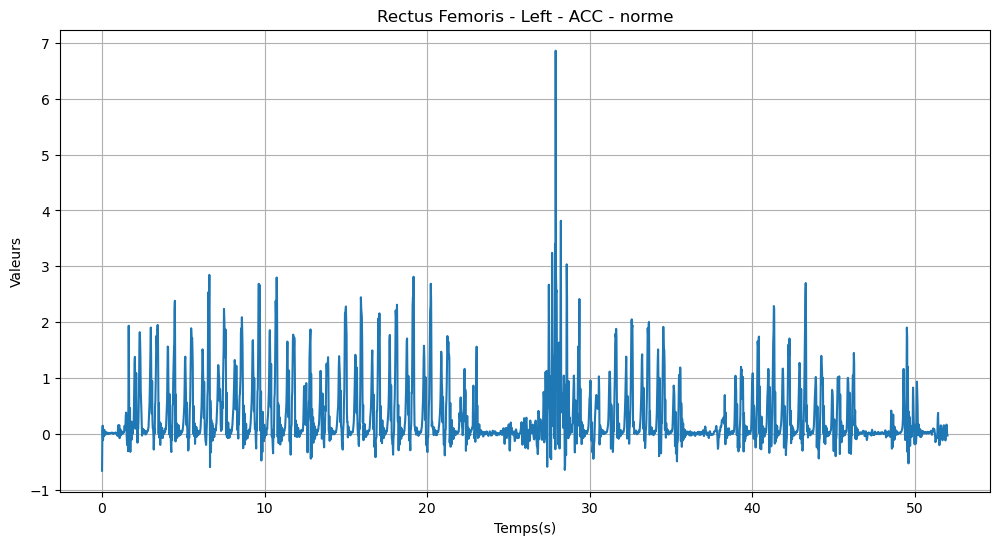

c:\Users\antho\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: x and y must have same first dimension, but have shapes (112,) and (2499,)

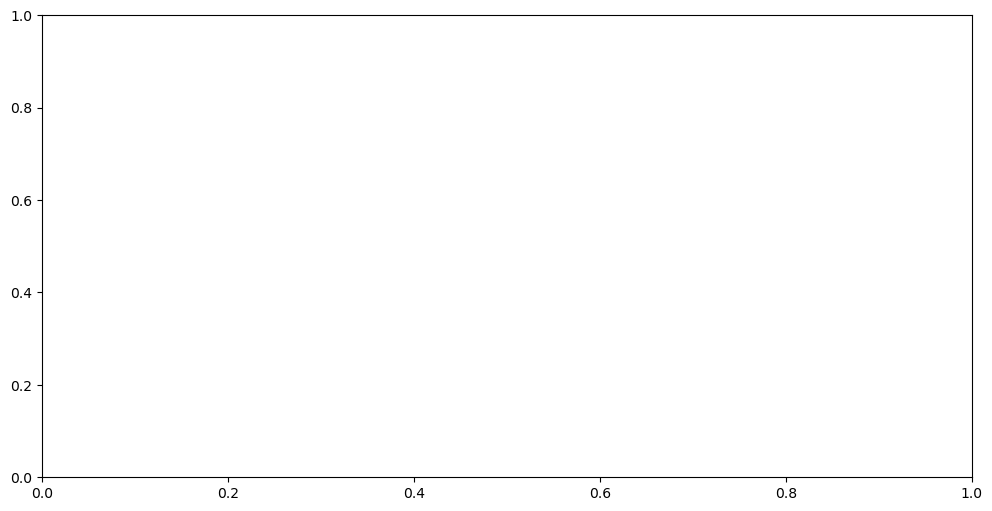

In [43]:
plot_data(donnees_patient_1, "Rectus Femoris", "Left","ACC", "norme", donnees_patient_1["metadata"]["Temps"])
plot_data(donnees_patient_16, "Rectus Femoris", "Right","ACC", "norme", donnees_patient_16["metadata"]["Temps"])


## Normaliser les données

Attention : pour les patients détectFOG il ne faudra pas oublier d'enlever la partie assise, avant de normaliser

### On crée un seuil sur l'axe de la norme du GYRO = 250

In [11]:
# from scipy.signal import find_peaks
# muscle_data = donnees_patient_3["Rectus Femoris"]["Right"]["ACC"]["norme"] #cheville gauche
# peak_indices, _ = find_peaks(muscle_data, height=0.2)

#     # S'il y a des pics, déterminer le premier et le dernier pic
# if peak_indices.size > 0:
#     start_index = peak_indices[0]
#     end_index = peak_indices[-1]
    
# #pour savoir à quel temps correspondent les pics nous allons générer le temps
# temps = donnees_patient_3["metadata"]["Temps"]
# FOG_d = donnees_patient_3["FOG"]

In [12]:
'''from scipy.signal import find_peaks

def extract_data_interval_from_peak(data,muscle_data, threshold=250):
    """
    Extrait un intervalle de données à partir d'un seuil, qui nous permettra de déterminer le début et la fin de la FOG.
    C'est à dire que le début correspondra au premier pic qui dépasse ce seuil et la fin au dernier pic.
    Libre à nous de choisir sur quel muscle nous voulons extraire un intervalle. 

    Parameters:
    - data (dict): Un dictionnaire contenant les données des capteurs.
    - muscle_data (array-like): Les données du muscle à partir desquelles extraire l'intervalle.
    - threshold (float, optional): Le seuil pour détecter les pics. Par défaut, 250.

    Returns:
    - data_interval (dict): Un dictionnaire contenant l'intervalle de données extrait.
    """
    
    # Trouver les pics dans les données du muscle
    peak_indices, _ = find_peaks(muscle_data, height=threshold) # Trouver les pics dans les données du muscle

    # S'il y a des pics, déterminer le premier et le dernier pic
    if peak_indices.size > 0: # S'il y a des pics
        start_index = peak_indices[0] # Déterminer l'indice du premier pic
        end_index = peak_indices[-1] # Déterminer l'indice du dernier pic

        # Extraire les données d'axes pour la plage de temps du premier au dernier pic
        data_interval = {}
        for sensor, sensor_data in data.items(): # Pour chaque capteur et ses données
            if sensor not in ["metadata", "Parcours", "FOG"]: # Si le capteur n'est pas "metadata", "Parcours" ou "FOG"
                data_interval[sensor] = {}
                for side, side_data in sensor_data.items():
                    data_interval[sensor][side] = {}
                    for measure, measure_data in side_data.items():
                        data_interval[sensor][side][measure] = {}
                        for axis, axis_data in measure_data.items():
                            data_interval[sensor][side][measure][axis] = axis_data[start_index:end_index + 1]

        # Copier les données de "metadata", "Parcours" et "FOG"
        data_interval["metadata"] = data["metadata"]
        data_interval["Parcours"] = data["Parcours"]
        data_interval["FOG"] = data["FOG"]

        # Extraire la plage de temps correspondante à la liste de temps dans metadata
        metadata_temps_interval = data["metadata"]["Temps"][start_index:end_index + 1]

        # Ajouter la plage de temps interval à metadata
        data_interval["metadata"]["Temps"] = metadata_temps_interval

        return data_interval
    else:
        return None

# Utilisation de la fonction
data_interval_from_peak = extract_data_interval_from_peak(donnees_patient_1,donnees_patient_1["Rectus Femoris"]["Left"]["GYRO"]["norme"])
rectus = data_interval_from_peak["Rectus Femoris"]["Left"]["GYRO"]["X"]
temps_1 = data_interval_from_peak["metadata"]["Temps"]'''

'from scipy.signal import find_peaks\n\ndef extract_data_interval_from_peak(data,muscle_data, threshold=250):\n    """\n    Extrait un intervalle de données à partir d\'un seuil, qui nous permettra de déterminer le début et la fin de la FOG.\n    C\'est à dire que le début correspondra au premier pic qui dépasse ce seuil et la fin au dernier pic.\n    Libre à nous de choisir sur quel muscle nous voulons extraire un intervalle. \n\n    Parameters:\n    - data (dict): Un dictionnaire contenant les données des capteurs.\n    - muscle_data (array-like): Les données du muscle à partir desquelles extraire l\'intervalle.\n    - threshold (float, optional): Le seuil pour détecter les pics. Par défaut, 250.\n\n    Returns:\n    - data_interval (dict): Un dictionnaire contenant l\'intervalle de données extrait.\n    """\n    \n    # Trouver les pics dans les données du muscle\n    peak_indices, _ = find_peaks(muscle_data, height=threshold) # Trouver les pics dans les données du muscle\n\n    # S

In [13]:
#plot_data(data_interval_from_peak, "Tibialis Anterior", "Left","GYRO", "norme", True, data_interval_from_peak["metadata"]["Temps"])

### Réduire les datas avec START et END pour avoir uniquement la position debout

In [3]:
def extract_data_interval(data):
    """
    Extrait un intervalle de données à partir du moment où le patient se lève jusqu'au dernier moment debout.

    Parameters:
    - data (dict): Un dictionnaire contenant les données des capteurs.

    Returns:
    - data_interval (dict): Un dictionnaire contenant l'intervalle de données extrait.
    """
    # Extraire les temps de début et de fin du parcours
    start_time = data["Parcours"]["START"][0] # Extraire le temps de début du parcours
    end_time = data["Parcours"]["END"][0] # Extraire le temps de fin du parcours
    epsilon=0.01 # Marge d'erreur

    # Trouver les indices correspondants dans le vecteur de temps pour le début du parcours
    for i, time in enumerate(data["metadata"]["Temps"]): # Pour chaque temps dans le vecteur de temps
        if abs(time - start_time) < epsilon:  # Vérifier si la différence est inférieure à la marge d'erreur
            start_index = i 
        if abs(time - end_time) < epsilon:
            end_index = i

    # Extraire les données d'axes pour la plage de temps START à END
    data_interval = {}
    for sensor, sensor_data in data.items():
        if sensor not in ["metadata", "Parcours", "FOG"]:
            data_interval[sensor] = {}
            for side, side_data in sensor_data.items():
                data_interval[sensor][side] = {}
                for measure, measure_data in side_data.items():
                    data_interval[sensor][side][measure] = {}
                    for axis, axis_data in measure_data.items():
                        data_interval[sensor][side][measure][axis] = axis_data[start_index:end_index+1]

    # Copier les données de "metadata", "Parcours" et "FOG"
    data_interval["metadata"] = data["metadata"]
    data_interval["Parcours"] = data["Parcours"]
    data_interval["FOG"] = data["FOG"]

    # Extraire la plage de temps START à END pour la liste de temps dans metadata
    metadata_temps_interval = data["metadata"]["Temps"][start_index:end_index+1]

    # Ajouter la plage de temps interval à metadata
    data_interval["metadata"]["Temps"] = metadata_temps_interval

    return data_interval

# Utilisation de la fonction
data_interval = extract_data_interval(donnees_patient_16_update)
data_interval_16 = extract_data_interval(donnees_patient_16)



Faut-il redéfinir le temps ? Pour avoir un temps de 0 à ... sachant que dans ces cas là il faudra redéfinir le temps pour chaque évènement

In [15]:
temps_16 = data_interval["metadata"]["Temps"]

### On applique maintenant la formule de normalisation

In [4]:
def normalize_data(data):
    """
    Normalise les données des capteurs.

    Parameters:
    - data (dict): Un dictionnaire contenant les données des capteurs.

    Returns:
    - normalized_data (dict): Un dictionnaire contenant les données normalisées.
    """
    normalized_data = {}
    for sensor, sensor_data in data.items():
        if sensor not in ["metadata", "Parcours", "FOG"]:
            normalized_data[sensor] = {}
            for side, side_data in sensor_data.items():
                normalized_data[sensor][side] = {}
                for measure, measure_data in side_data.items():
                    normalized_data[sensor][side][measure] = {}
                    for axis, axis_data in measure_data.items():
                        # Calculer la moyenne, le maximum et le minimum des données
                        mean = np.mean(axis_data)
                        max_val = np.max(axis_data)
                        min_val = np.min(axis_data)
                        # Appliquer la normalisation sur tous les axes X,Y,Z et la norme
                        normalized_axis_data = (axis_data - mean) / (max_val - min_val)
                        normalized_data[sensor][side][measure][axis] = normalized_axis_data
    
    # Copier les données de "metadata", "Parcours" et "FOG"
    normalized_data["metadata"] = data["metadata"]
    normalized_data["Parcours"] = data["Parcours"]
    normalized_data["FOG"] = data["FOG"]
    
    return normalized_data


normalized_data = normalize_data(data_interval)
normalized_data_16 = normalize_data(data_interval_16)


In [17]:
tibia_gyro = donnees_patient_16_update["Tibialis Anterior"]["Left"]["GYRO"]["norme"]
temps_16 = normalized_data_16["metadata"]["Temps"]
temps = normalized_data["metadata"]["Temps"]

In [44]:
plot_data(normalized_data_16, "Tibialis Anterior", "Left","GYRO", "norme", True, normalized_data_16["metadata"]["Temps"])
#plot_data(donnees_patient_16_update, "Tibialis Anterior", "Left","GYRO", "norme", True, donnees_patient_16_update["metadata"]["Temps"])
'''Le deuxième graph ne fonctionne pas, car j'ai l'impression que le temps à été modifié par la fonction extract_data_interval
même si le temps est modifié à l'intérieur de la fonction'''

TypeError: plot_data() takes 6 positional arguments but 7 were given

# Fenêtrage

In [5]:
def decoupage_en_fenetres(data, taille_fenetre, decalage, taux_echantillonnage):
    fenetres_data = {}
    infos_fenetres = {}

    for sensor, sensor_data in data.items():
        if sensor not in ["metadata", "Parcours", "FOG"]:
            fenetres_data[sensor] = {}
            infos_fenetres[sensor] = {}

            for side, side_data in sensor_data.items():
                fenetres_data[sensor][side] = {}
                infos_fenetres[sensor][side] = {}

                for measure, measure_data in side_data.items():
                    fenetres_data[sensor][side][measure] = {}
                    infos_fenetres[sensor][side][measure] = {}

                    for axis, axis_data in measure_data.items():
                        taille_signal = len(axis_data)
                        taille_fenetre_echantillons = int(taille_fenetre * taux_echantillonnage)
                        decalage_fenetre = int(decalage * taille_fenetre_echantillons)

                        fenetres = []
                        debut = 0
                        fin = taille_fenetre_echantillons
                        nb_fenetres = 0

                        while fin <= taille_signal:
                            fenetre = axis_data[debut:fin]
                            fenetres.append(fenetre)

                            debut = debut + decalage_fenetre
                            fin = fin + decalage_fenetre
                            nb_fenetres += 1

                        if debut < taille_signal:
                            fenetre = axis_data[debut:]
                            fenetres.append(fenetre)

                        fenetres_data[sensor][side][measure][axis] = fenetres
                        infos_fenetres[sensor][side][measure][axis] = {
                            "nombre_fenetres": nb_fenetres,
                            "taille_fenetre": taille_fenetre_echantillons,
                            "decalage_fenetre": decalage_fenetre
                        }

    # Traitement des nouvelles données de temps
    temps = data["metadata"]["Temps"]
    taille_signal_temps = len(temps)
    taille_fenetre_temps = int(taille_fenetre * taux_echantillonnage)
    decalage_fenetre_temps = int(decalage * taille_fenetre_temps)

    fenetres_temps = []
    debut_temps = 0
    fin_temps = taille_fenetre_temps

    while fin_temps <= taille_signal_temps:
        fenetre_temps = temps[debut_temps:fin_temps]
        fenetres_temps.append(fenetre_temps)

        debut_temps += decalage_fenetre_temps
        fin_temps += decalage_fenetre_temps

    if debut_temps < taille_signal_temps:
        fenetre_temps = temps[debut_temps:]
        fenetres_temps.append(fenetre_temps)

    # Copie des données de "metadata", "Parcours" et "FOG"
    fenetres_data["metadata"] = data["metadata"]
    fenetres_data["Parcours"] = data["Parcours"]
    fenetres_data["FOG"] = data["FOG"]
    
    # Remplacement des anciennes données de temps par les nouvelles
    fenetres_data["metadata"]["Temps"] = fenetres_temps

    return fenetres_data, infos_fenetres

fenetres_data, infos_fenetres = decoupage_en_fenetres(normalized_data, taille_fenetre = 2, decalage=0.2, taux_echantillonnage=50)
fenetres_data_16, infos_fenetres_16 = decoupage_en_fenetres(normalized_data_16, taille_fenetre = 2, decalage=0.2, taux_echantillonnage=50)

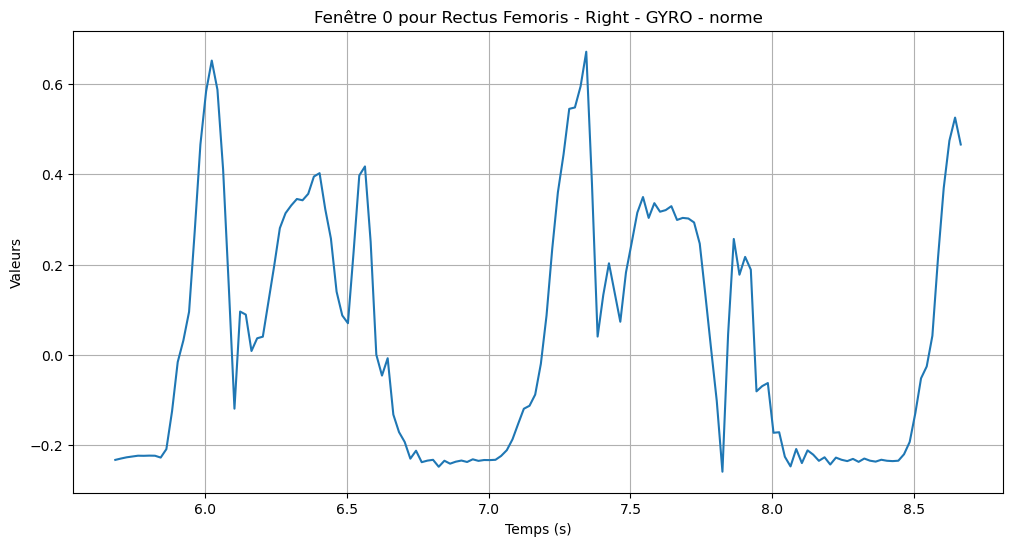

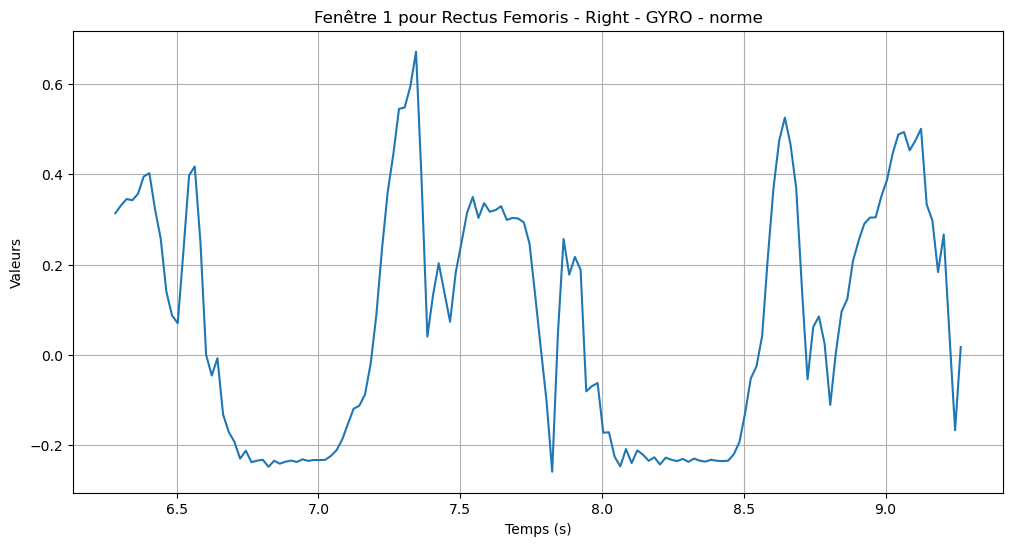

In [ ]:
def plot_data_window(data, temps, window_index, muscle, side, sensor_type, axis):
    """
    Plot a window of inertial data from a patient with its corresponding time.
    
    Parameters:
        data (dict): Dictionary containing the patient's inertial data.
        temps (list): List of time values.
        window_index (int): Index of the window to plot.
        muscle (str): Muscle name (e.g., "Tibialis Anterior").
        side (str): Side of the patient (e.g., "Left" or "Right").
        sensor_type (str): Type of sensor data (e.g., "GYRO" or "ACC").
        axis (str): Axis of the sensor data (e.g., "x", "y", or "z").
    """
    # Sélectionner la fenêtre de données et son temps correspondant
    window_data = data[muscle][side][sensor_type][axis][window_index]
    window_time = temps[window_index]
    
    # Créer le graphique
    plt.figure(figsize=(12, 6))
    plt.plot(window_time, window_data)
    plt.title(f"Fenêtre {window_index} pour {muscle} - {side} - {sensor_type} - {axis}")
    plt.xlabel("Temps (s)")
    plt.ylabel("Valeurs")
    plt.grid(True)
    plt.show()

# Exemple d'utilisation
plot_data_window(fenetres_data, fenetres_data["metadata"]["Temps"], 0, "Rectus Femoris", "Right", "GYRO", "norme")
plot_data_window(fenetres_data, fenetres_data["metadata"]["Temps"], 1, "Rectus Femoris", "Right", "GYRO", "norme")



## Classer les fenêtres en NON-FOG, pré-FOG ou FOG

## Labelliser FOG ou NON-FOG

In [ ]:
# def classify_windows(data, fog_start, fog_end):
#     classified_windows = []
#     fog_intervals = [(debut, fin) for debut, fin in zip(fog_start, fog_end)]
#     fog_indices = []  # Liste pour stocker les indices des fenêtres FOG
    
#     for window in data:
#         fog_count = sum(1 for t in window if any(debut <= t <= fin for debut, fin in fog_intervals))
#         fog_detected = fog_count / len(window) >= 0.5
#         classified_windows.append("FOG" if fog_detected else "NON FOG")
    
#     # Stocker les indices des fenêtres FOG
#     for i, classification in enumerate(classified_windows):
#         if classification == "FOG":
#             fog_indices.append(i)
    
#     # Marquer les fenêtres précédentes des séquences de FOG comme "PRE FOG"
#     for fog_index in fog_indices:
#         start_index = fog_index
#         if classified_windows[start_index - 1] != "FOG":
#             classified_windows[start_index - 1] = "PRE FOG"
    
#     return classified_windows

Le problème dans l'attribution des labels de fenêtres est que lorsque une fenêtre est inférieur à 50% de FOG, cela veut dire que la fenêtre qui précède FOG est labellisé comme pré FOG, donc dans une fenêtre pré FOG il y a toujours un peu de FOG 

# Labelisation avec transition PRE FOG, trnaistion FOG, etc...

#### Intégrer les conditions fusion FOG et exclusion FOG

A savoir qu'on va réunir les FOG qui apparaissent consécutivement sur une période de moins de 2 secondes

A savoir qu'on va supprimer les FOG qui font moins de 1 seconde

In [ ]:
# events=pd.DataFrame({'temps': debuts_fog + fins_fog, 
#                      'events': ["debut_fog"]*len(debuts_fog) + ["fin_fog"]*len(fins_fog)}).sort_values('temps').reset_index(drop=True)

# print(events)


       temps     events
0  25.953333  debut_fog
1  28.226667    fin_fog
2  45.726665  debut_fog
3  46.793335    fin_fog


In [ ]:
# # Calculer la différence entre les timestamps pour chaque début et fin de FOG
# events['diff'] = events['temps'].diff()
# print(events)

       temps     events       diff
0  25.953333  debut_fog        NaN
1  28.226667    fin_fog   2.273335
2  45.726665  debut_fog  17.499998
3  46.793335    fin_fog   1.066669


In [ ]:
# data = {
#     'temps': [1, 2, 5, 8, 9, 10],
#     'events': ['debut_fog', 'fin_fog', 'debut_fog', 'fin_fog', 'debut_fog', 'fin_fog'],
#     'diff': [None, 1, 3, 3, 1, 1]
# }

# events = pd.DataFrame(data)
# print(events)

   temps     events  diff
0      1  debut_fog   NaN
1      2    fin_fog   1.0
2      5  debut_fog   3.0
3      8    fin_fog   3.0
4      9  debut_fog   1.0
5     10    fin_fog   1.0


In [ ]:
# # Supprimer les lignes pour lesquelles finfog est <=2 secondes et par conséquent debut_fog
# indices_a_supprimer = events[((events['events'] == 'fin_fog') & (events['diff'] <= 2))].index.union(events[((events['events'] == 'fin_fog') & (events['diff'] <= 2))].index - 1)
# events = events.drop(indices_a_supprimer)
# events.reset_index(drop=True)

# events['diff'] = events['temps'].diff()

# print(events)

   temps     events  diff
2      5  debut_fog   NaN
3      8    fin_fog   3.0


In [ ]:
# # Fusion FOG si l'écart entre fin_fog et debut_fog est inférieur à 2 secondes
# indices_a_supprimer_pour_fusion = events[((events['events'] == 'debut_fog') & (events['diff'] <= 2))].index.union(events[((events['events'] == 'debut_fog') & (events['diff'] <= 2))].index - 1)
# events = events.drop(indices_a_supprimer_pour_fusion)


#### On ne prend pas en compte le regroupement de FOG, ni l'extraction des FOG < à un certains temps

In [22]:
temps = fenetres_data_16["metadata"]["Temps"]
debuts_fog = fenetres_data_16["FOG"]["Debut"]
fins_fog = fenetres_data_16["FOG"]["Fin"]
status="NoFOG"
    
    # on stock les données d'évènement dans un dataframe ordonner en fonction du temps
events=pd.DataFrame({'temps': debuts_fog + fins_fog, 
                    'events': ["debut_fog"]*len(debuts_fog) + ["fin_fog"]*len(fins_fog)}).sort_values('temps').reset_index(drop=True)

    # On récupère si il y a un évènement de FOG ou plusieurs de présent de la FOG
statuses = []
status = "NoFog"

for window in temps:
    w_start = window[0]
    w_end = window[-1]
    window_events = []  # Liste pour stocker les événements de la fenêtre
    
    for _, row in events.iterrows():
        if row['temps'] >= w_start and row['temps'] <= w_end:
            window_events.append(row['events'])  # Ajouter l'événement à la liste
    
    # if not window_events:  # Si la liste est vide
    #     window_events = [None]  # Remplir avec None

In [23]:
print(window_events)

[]


#### Mettre les labels FOG, pré FOG, Non FOG

In [83]:
def label_fenetre(data,temps_prefog = 3):
    temps = data["metadata"]["Temps"]
    debuts_fog = data["FOG"]["Debut"]
    fins_fog = data["FOG"]["Fin"]
    debuts_prefog = [x-temps_prefog for x in debuts_fog]
    
    
    # on stock les données d'évènement dans un dataframe ordonner en fonction du temps
    events=pd.DataFrame({'temps': debuts_fog + fins_fog + debuts_prefog, 
                    'events': ["debut_fog"]*len(debuts_fog) + ["fin_fog"]*len(fins_fog) + ["preFog"]*len(debuts_prefog)}).sort_values('temps').reset_index(drop=True)

    # On récupère si il y a un évènement de FOG ou plusieurs de présent de la FOG
    statuses = []
    status = "NoFog"

    for window in temps:
        w_start = window[0] # premier terme de la fenêtre
        w_end = window[-1] # dernier terme de la fenêtre
        window_events = []  # Liste pour stocker les événements de la fenêtre
        time=[]
        time_pourcent = 1 
        
        for _, row in events.iterrows():
            if row['temps'] >= w_start and row['temps'] <= w_end: #si le temps correspondant à l'évènement se trouve entre début et fin de la fenêtre
                window_events.append(row['events'])  # Ajouter l'événement à la liste
                if row['events']== "fin_fog": # si l'évènement est fin_fog
                    time.append(row["temps"])
                                    
        if len(window_events)==1 and "fin_fog" in window_events: #si on oa une liste avec uniquement fin_fog
             time_array = np.arange(w_start,w_end,1/50)
             time_pourcent = np.sum(time_array<=time)/100
    
        if not window_events:  # Si la liste est vide
            window_events = [None]  # Remplir avec None
    
        # if status == "NoFog" and "preFog" in window_events:
        #     status = "transitionPreFog"
        
        # elif status == "transitionPreFog" and None in window_events:
        #     status = "preFog"
            
        if status == "NoFog" and "debut_fog" in window_events: # si la fenêtre contient debut_fog et son statu est NoFog
            status = "transitionFog"
            
        elif status == "transitionFog" and None in window_events: #si le FOG est suffisement long pour ne pas rencontrer d'évènement après debut_Fog alors :
            status = "Fog"
        
        elif "debut_fog" in window_events and "fin_fog" in window_events: #si il est petit alors la fenêtre peut comporter l'évènement de début et de fin
            status = "Fog"
            
        elif status =="Fog" and ("debut_fog" in window_events and "fin_fog" in window_events): # dans le cas où des FOG sont succints, donc c'est à dire quand la fenêtre comporte fin_fog et debut du fog suivant alors :  
            status= "transitionFog"
        
        elif status == "Fog" and "fin_fog" in window_events and time_pourcent <= 0.5: # si on a un FOG inférieur à 50% de la longueur de fenêtre, alors : 
        # on s'en fiche de faire cette opération avant, car dans tous les cas on considère FOG lorsqu'il y a deux évènements dans la fenêtre et on prend pour cible transitionFog,donc que ce soit FOG ou transition ce sera dans cible. 
            status = "transitionNoFog"
            
        elif status == "transitionNoFog" and None in window_events:
            status = "NoFog"
        
        statuses.append(status)  # Ajouter le statut à la liste des statuts
        
    # on associe les labels de fenêtre dans notre data
    data["labels_fenetres"] = statuses
    return data

In [84]:
statuses_16=label_fenetre(fenetres_data_16)
print(statuses_16["labels_fenetres"])

['NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'transitionFog', 'transitionFog', 'transitionFog', 'transitionFog', 'transitionFog', 'Fog', 'Fog', 'Fog', 'transitionNoFog', 'transitionNoFog', 'transitionNoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'transit

In [30]:
print(fenetres_data_16["FOG"])

{'Debut': [25.953332901000977, 45.72666549682617], 'Fin': [28.226667404174805, 46.7933349609375]}


In [42]:
satuses=label_fenetre(fenetres_data)

c= statuses_16["labels_fenetres"]
print(len(c))

112


In [43]:
print(c)

['NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'transitionPreFog', 'transitionPreFog', 'transitionPreFog', 'transitionPreFog', 'transitionPreFog', 'preFog', 'preFog', 'transitionFog', 'transitionFog', 'transitionFog', 'transitionFog', 'transitionFog', 'Fog', 'transitionNoFog', 'transitionNoFog', 'transitionNoFog', 'transitionNoFog', 'transitionNoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog', 'NoFog',

#### Maintenant j'aimerais définir le label de chaque fenêtre en clé de données

In [9]:
def association_label_fenetre_data(satuses):
    association_label_fenetre_data = {}
    for sensor, sensor_data in satuses.items():
        if sensor not in ["metadata", "Parcours", "FOG", "labels_fenetres"]:
            association_label_fenetre_data[sensor] = {}
            for side, side_data in sensor_data.items():
                association_label_fenetre_data[sensor][side] = {}

                for measure, measure_data in side_data.items():
                    association_label_fenetre_data[sensor][side][measure] = {}
                    
                    for axis, axis_data in measure_data.items():
                        association_label_fenetre_data[sensor][side][measure][axis] = {}
                        presentWin=np.unique(satuses["labels_fenetres"])
                        for label in presentWin:
                            #data_list = axis_data
                            data_frame_axis_data= pd.DataFrame(axis_data)
                            association_label_fenetre_data[sensor][side][measure][axis][label]=data_frame_axis_data[[x==label for x in satuses["labels_fenetres"]]]
    
        # Copie des données de "metadata", "Parcours" et "FOG"
    association_label_fenetre_data["metadata"] = satuses["metadata"]
    association_label_fenetre_data["Parcours"] = satuses["Parcours"]
    association_label_fenetre_data["FOG"] = satuses["FOG"]

    association_label_fenetre_data["FOG"] = {
        "Debut": satuses["FOG"]["Debut"],
        "Fin": satuses["FOG"]["Fin"],
        "preFog": [max(0, x - 3) for x in satuses["FOG"]["Debut"]]
    }
    return association_label_fenetre_data 

In [11]:
temp=association_label_fenetre_data(satuses)
temp_16=association_label_fenetre_data(statuses_16)
print(temp["Tibialis Anterior"]["Left"]["GYRO"]["norme"]["NoFog"])
print(temp["FOG"]["Debut"])

print(temp)

          0         1         2         3         4         5         6   \
0  -0.100239 -0.112198 -0.120973 -0.101456 -0.059053 -0.024817  0.017692   
1   0.117071  0.222018 -0.023972  0.044511  0.018969 -0.026009 -0.080430   
2  -0.127283 -0.126352 -0.081382 -0.111044 -0.148756 -0.124399 -0.043276   
3  -0.099684 -0.097097 -0.088779 -0.128004 -0.144398 -0.118242 -0.076567   
4   0.162713  0.168808  0.270012  0.265388  0.143870  0.159328  0.022321   
..       ...       ...       ...       ...       ...       ...       ...   
82  0.040414  0.029077  0.067774  0.322118  0.000341  0.096076  0.042920   
83 -0.070503 -0.013087 -0.031786 -0.095345 -0.151373 -0.101889 -0.079569   
84 -0.155217 -0.158452 -0.139334 -0.089741 -0.004434  0.070497  0.013510   
85 -0.154987 -0.115886 -0.136265 -0.182089 -0.158400 -0.117026 -0.111497   
86 -0.062460 -0.004686  0.085274  0.042752 -0.062028 -0.110845 -0.083745   

          7         8         9   ...        90        91        92        93  \
0   0.

# Statistiques

In [12]:
temp_16["metadata"]["Temps"] = pd.DataFrame(temp_16["metadata"]["Temps"])

In [68]:
a = temp_16["metadata"]["Temps"]

In [13]:
first_time= temp_16["metadata"]["Temps"].iloc[0,0]
if np.isnan(temp_16["metadata"]["Temps"].iloc[-1,-1]):
    first_na = np.where(np.isnan(temp_16["metadata"]["Temps"]))[-1][0]
    last_time = temp_16["metadata"]["Temps"].iloc[-1,(first_na-1)]
else:
    last_time = temp_16["metadata"]["Temps"].iloc[-1,-1]

print(last_time)


temps_total = last_time - first_time
print("Temps total de l'enregistrement :", temps_total, "secondes")

if  temp_16["FOG"]["Debut"] == [0] :
    nb_fog = 0
    print(f"Nombre de FOG : {nb_fog}")
else :
    nb_fog = len(temp_16["FOG"]["Debut"])
    print(f"Nombre de FOG : {nb_fog}")

temps_fog = sum([fin - debut for debut, fin in zip(temp_16["FOG"]["Debut"], temp_16["FOG"]["Fin"])])
prct_fog = (temps_fog / temps_total) * 100
print(f"Pourcentage total de FOG sur la totalité de l'enregistrement : {prct_fog:.2f}%")



48.92610088070456
Temps total de l'enregistrement : 46.06457432612756 secondes
Nombre de FOG : 2
Pourcentage total de FOG sur la totalité de l'enregistrement : 7.25%


In [26]:
temps_test =temp_16["metadata"]["Temps"]
nb_fenetre = len(temp_16["metadata"]["Temps"])
nb_colonne = len(temp_16["metadata"]["Temps"].columns)
print(f"Nombre de fenêtres : {nb_fenetre}")
print(f"Nombre de colonnes : {nb_colonne}")

Nombre de fenêtres : 112
Nombre de colonnes : 100


In [28]:
tab_stat= pd.DataFrame({"Temps total de l'enregistrement": [temps_total], "Nombre de FOG": [nb_fog], "Pourcentage total de FOG": [prct_fog], "nombre de fenêtres": [nb_fenetre], "longueur des fenêtres": [nb_colonne]})
print(tab_stat)

   Temps total de l'enregistrement  Nombre de FOG  Pourcentage total de FOG  \
0                        46.064574              2                    7.2507   

   nombre de fenêtres  longueur des fenêtres  
0                 112                    100  


In [33]:
temps_fog = [fin - debut for debut, fin in zip(temp_16["FOG"]["Debut"], temp_16["FOG"]["Fin"])]
tab_fog = pd.DataFrame({"Debut": temp_16["FOG"]["Debut"], "Fin": temp_16["FOG"]["Fin"], "Total" : temps_fog})
print(tab_fog)

ValueError: All arrays must be of the same length

In [66]:
temp_16["metadata"]["Temps"] = pd.DataFrame(temp_16["metadata"]["Temps"])
print(temp_16["metadata"]["Temps"].iloc[0,0])
# Trouver l'indice de la dernière valeur non nulle
# Trouver la dernière valeur non nulle avant NaN dans la dernière colonne
first_na=np.where(np.isnan(temp_16["metadata"]["Temps"]))[-1][0]
last_time=temp_16["metadata"]["Temps"].iloc[-1,(first_na-1)]
print(last_time)

2.8615265545769946
48.92610088070456


# ____________________________________________________________________________________________________________________________________________________________________________________________________

## Conversion C3D en JSON sans rééchantillonnage, ni filtre

In [ ]:
def recuperer_evenements(file_path):
    c3d = ezc3d.c3d(file_path)
    events = c3d['parameters']['EVENT']['LABELS']['value']
    frames = c3d['parameters']['EVENT']['TIMES']['value']
    events_dict = {}
    for event, frame in zip(events, frames):
        events_dict[event] = frame
    return events_dict

def associer_labels_et_data(file_path):
    c3d = ezc3d.c3d(file_path)
    labels = c3d['parameters']['ANALOG']['LABELS']['value']
    frequence = c3d['parameters']['ANALOG']['RATE']['value'][0]
    data = c3d['data']['analogs']
    nb_frame = len(data[0][0])
    temps = np.linspace(0., nb_frame / frequence, num=nb_frame)
    fusion_label_data = {}
    for i, label in enumerate(labels):
        fusion_label_data[label] = data[0][i, :]
    return fusion_label_data, temps   # Dictionnaire avec tous les labels associés aux données

def filtrer_labels(fusion_label_data):
    labels_filtre = []
    labels_data_filtre = {}
    for label, valeurs in fusion_label_data.items():
        if 'ACC' in label or 'GYRO' in label:
            labels_filtre.append(label)
            labels_data_filtre[label] = valeurs
    return labels_filtre, labels_data_filtre # Dictionnaire avec les labels filtrés et les données associées

def calcul_norme(labels_data_filtre):
    normes = {}
    traite = set()
    for key, value in labels_data_filtre.items():
        parts = key.split('_')
        sensor = parts[0]
        side = parts[1]
        measure = parts[2]
        axes = parts[3]
        
        if (sensor, side, measure) not in traite:
            traite.add((sensor, side, measure))
            
            if "ACC" in measure:
                # Obtention des axes X, Y et Z
                axe_X = labels_data_filtre[f'{sensor}_{side}_{measure}_X']
                axe_Y = labels_data_filtre[f'{sensor}_{side}_{measure}_Y']
                axe_Z = labels_data_filtre[f'{sensor}_{side}_{measure}_Z']
            
                norme = np.sqrt(axe_X**2 + axe_Y**2 + axe_Z**2) - 1
                nom_cle = f'{sensor}_{side}_{measure}_norme'
                normes[nom_cle] = norme
                
            else :
                axe_X = labels_data_filtre[f'{sensor}_{side}_{measure}_X']
                axe_Y = labels_data_filtre[f'{sensor}_{side}_{measure}_Y']
                axe_Z = labels_data_filtre[f'{sensor}_{side}_{measure}_Z']
        
                norme = np.sqrt(axe_X**2 + axe_Y**2 + axe_Z**2)
                nom_cle = f'{sensor}_{side}_{measure}_norme'
                normes[nom_cle] = norme

    return normes

def creer_structure_json(labels_data_filtre, patient_id, date_de_naissance, medicaments, temps, events_dict, normes):
    json_data = {
        "metadata": {
            "Détails du patient": {
                "Identifiant": patient_id,
                "Date de naissance": date_de_naissance,
                "Medicaments": medicaments
            },
            "Temps": temps.tolist()
        }
    }
    
    for key, value in labels_data_filtre.items():
        parts = key.split('_')
        sensor = parts[1]
        side = parts[0]
        measure = parts[2]
        axis = parts[3]
        
        if sensor not in json_data:
            json_data[sensor] = {}

        if side not in json_data[sensor]:
            json_data[sensor][side] = {}

        if measure not in json_data[sensor][side]:
            json_data[sensor][side][measure] = {}

        json_data[sensor][side][measure][axis] = value.tolist()
        
    for key in normes:
        parts = key.split('_')
        sensor = parts[1]
        side = parts[0]
        measure = parts[2]
        axis = parts[3]

        if sensor not in json_data:
            json_data[sensor] = {}

        if side not in json_data[sensor]:
            json_data[sensor][side] = {}

        if measure not in json_data[sensor][side]:
            json_data[sensor][side][measure] = {}

        # Insérer la norme au même niveau d'indentation que l'axe
        json_data[sensor][side][measure][axis] = value.tolist()
        json_data[sensor][side][measure]["norme"] = normes[key].tolist()
    
        # Ajouter les événements FOG
    json_data["FOG"] = {
        "Debut": events_dict["FOG_begin"].tolist(),
        "Fin": events_dict["FOG_end"].tolist()
    }
    
    
    return json_data

    


def creation_json_grace_c3d(file_path, patient_id, date_de_naissance, medicaments, output_path):
    events_dict = recuperer_evenements(file_path) 
    fusion_label_data, temps = associer_labels_et_data(file_path)
    labels_filtre, labels_data_filtre = filtrer_labels(fusion_label_data)
    normes = calcul_norme(labels_data_filtre)
    json_structure = creer_structure_json(labels_data_filtre, patient_id, date_de_naissance, medicaments, temps, events_dict, normes)
    
    with open(output_path, "w") as fichier_json:
        json.dump(json_structure, fichier_json, indent=4)

# Utilisation de la fonction pour traiter le fichier C3D et générer le fichier JSON
fichier_brut = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATA_FOG/LE_LIEVRE_Emmanuel_1971_03_19_LEEM1971/2023-05-26/2023-05-26_overlay_detectFOG/Video_overlay_3.c3d"
patient_id = 1234
date_de_naissance = 45
medicaments = "ON"
chemin_sortie = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/video_overlay_3.json"

creation_json_grace_c3d(fichier_brut, patient_id, date_de_naissance, medicaments, chemin_sortie)


In [ ]:
# Charger le fichier JSON
chemin_fichier_json = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATABASE/video_overlay_3.json"
with open(chemin_fichier_json, "r") as fichier_json:
    donnees_patient = json.load(fichier_json)

# Accéder aux données spécifiques
accelerometre_left_Z_rectus_femoris = donnees_patient["Vastus Lateralis"]["Left"]["GYRO"]["norme"]